# Argo one filter scale

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import argopy
import scipy.ndimage as filter
import cartopy.crs as ccrs
import cartopy
import xrft
import scipy
import matplotlib

### Things to work on:
- For new filtering functions:
    - need to make new mask variable that will enable boundary correction feature <-- COMPLETE
    - need to use mask to selectively filter TEMP not included in boundary conditions
- Use these functions to perform the above calculations about "MKE" and "EKE" on one scale:
    - Pass temperature signal through filter at l=100m, then square the results <-- MKE
    - Square the temperature signal, pass it through filter at l=100m, then subtract MKE <-- EKE

### Load and plot data

In [2]:
import my_stats

In [3]:
#glider data
ds_660_grid = xr.open_dataset('ctd_660_vert_4m_binned_29_june_2021.nc')
gselect=ds_660_grid.sel(dives=slice(50,450),ctd_pressure=slice(200,900))
gselect_filt=my_stats.glider_ds_filt(gselect,1,4,50)
gselect_var=my_stats.glider_var(gselect,gselect_filt)

#argo box
box=xr.open_dataset("202206_lon:(30,40)_lat:(-55,-50).nc")
aselect=my_stats.get_ds_interp(box,0,2000,4)
aselect_filt=my_stats.get_ds_filt(aselect,1,4,50)
aselect_var=my_stats.get_var(aselect,aselect_filt)

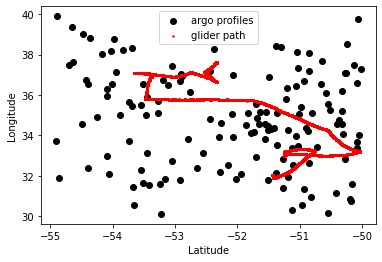

In [4]:
plt.scatter(aselect.LATITUDE,aselect.LONGITUDE,color='black',label='argo profiles')
plt.scatter(gselect.latitude,gselect.longitude,color='r',s=2,label='glider path')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()

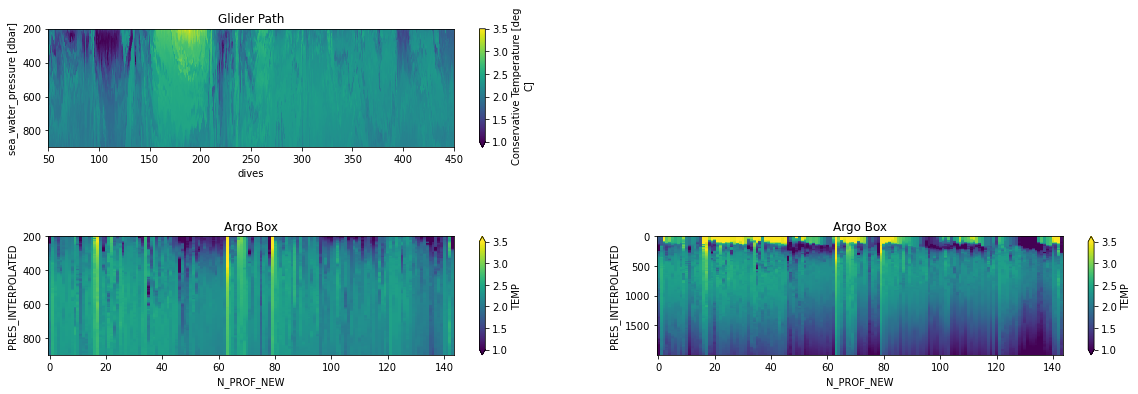

In [370]:
plt.figure(figsize=(20,6))

plt.subplot(2,2,1)
gselect.CT.plot(x='dives',y='ctd_pressure',vmin=1,vmax=3.5)
plt.gca().invert_yaxis()
plt.title('Glider Path')

plt.subplot(2,2,3)
aselect.TEMP.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',vmin=1,vmax=3.5)
plt.ylim(200,900)
plt.gca().invert_yaxis()
plt.title('Argo Box')

plt.subplot(2,2,4)
aselect.TEMP.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',vmin=1,vmax=3.5)
plt.gca().invert_yaxis()
plt.title('Argo Box')

plt.subplots_adjust(hspace=0.75)

## Dhruv's filtering methods/functions

In [6]:
import funcs

In [7]:
dx = (aselect.PRES_INTERPOLATED.isel(PRES_INTERPOLATED=1)-aselect.PRES_INTERPOLATED.isel(PRES_INTERPOLATED=0)).values
N = len(aselect.PRES_INTERPOLATED) +1
lfilter = 50*dx
sigmafilter = lfilter/np.sqrt(12)

nfilter_hat = lfilter/dx 
nfilter_gauss = sigmafilter/dx

f_hat = funcs.top_hat_kernel(nfilter_hat, N/2-1)
f_gauss = funcs.gaussian_kernel(nfilter_gauss, N/2-1)

Text(0, 0.5, 'PRES_INTERPOLATED [m]')

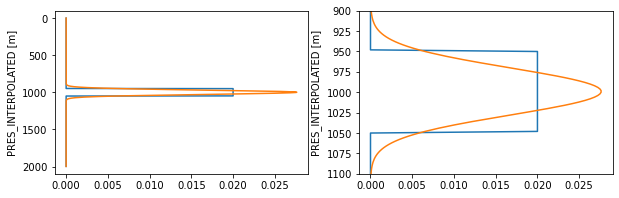

In [251]:
plt.figure(figsize=(10,3))
x=aselect.PRES_INTERPOLATED

plt.subplot(1,2,1)
plt.plot(f_hat, x)
plt.plot(f_gauss, x)
plt.gca().invert_yaxis()
plt.ylabel('PRES_INTERPOLATED [m]')

plt.subplot(1,2,2)
plt.plot(f_hat, x)
plt.plot(f_gauss, x)
plt.ylim(900,1100)
plt.gca().invert_yaxis()
plt.ylabel('PRES_INTERPOLATED [m]')

In [9]:
f = aselect.TEMP.isel(N_PROF=0)
f_num = int(f.N_PROF)

f_l_hat = funcs.my_filter1d(f.values, nfilter_hat, funcs.top_hat_kernel, mode='wrap')
f_l_gauss = funcs.my_filter1d(f.values, nfilter_gauss, funcs.gaussian_kernel, mode='wrap')

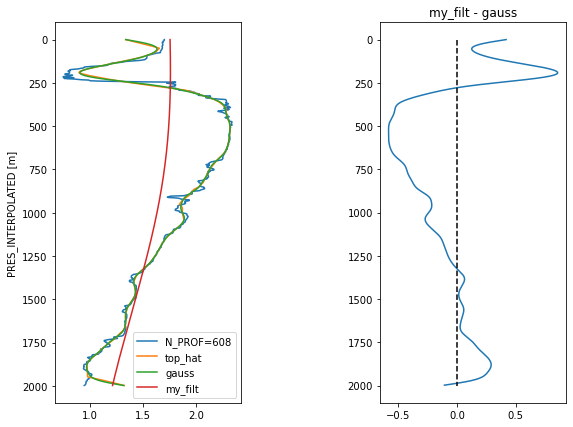

In [237]:
plt.figure(figsize=(15,7))

plt.subplot(1,3,1)
plt.plot(f, x, label='N_PROF={}'.format(f_num))
plt.plot(f_l_hat, x, label='top_hat')
plt.plot(f_l_gauss, x, label='gauss')
plt.plot(aselect_filt.sel(N_PROF=f_num).isel(FILT_SCALE=35), x, label='my_filt')
plt.gca().invert_yaxis()
plt.ylabel('PRES_INTERPOLATED [m]')
plt.legend()

plt.subplot(1,3,2)
plt.plot(aselect_filt.sel(N_PROF=f_num).isel(FILT_SCALE=35)-f_l_gauss, x)
plt.vlines(0,0,2000, linestyles='dashed', color='black')
plt.gca().invert_yaxis()
plt.title('my_filt - gauss')

plt.subplots_adjust(wspace=0.75)

There are obviously some differences between Dhruv's functions and mine. Need to combine the functionality of both:
- Dhruv's functions: use this method to determine dx, N, etc. Function should read in filter scale input of meters.
- My functions: use this method to repeatedly filter at multiple scales. Function should return a nicely formatted xr array.
- Added functionality: Should read in scale in meters, be able to apply a boundary correction, and maybe pick between filter scales arranged on a linear and log axis (for ds_multi_scale)

## Correcting my get_ds_interp function

In [12]:
import scipy.ndimage as filter
from funcs import convolve1d

### Function to return single profile filtered at one scale

In [371]:
def prof_one_scale(prof, scale, boundary_correction=False):
    #add boundary correction mask once you figure that out
    
    dx = (prof.PRES_INTERPOLATED.isel(PRES_INTERPOLATED=1)-prof.PRES_INTERPOLATED.isel(PRES_INTERPOLATED=0)).values
    N = len(prof.PRES_INTERPOLATED)+1
    lfilter = scale
    sigmafilter = lfilter/np.sqrt(12)
    nfilter = sigmafilter/dx

    prof_filt = filter.gaussian_filter1d(prof, sigma=nfilter, mode='wrap')
    
    return prof_filt

In [235]:
prof_filt = prof_one_scale(aselect.TEMP.sel(N_PROF=f_num), 100)

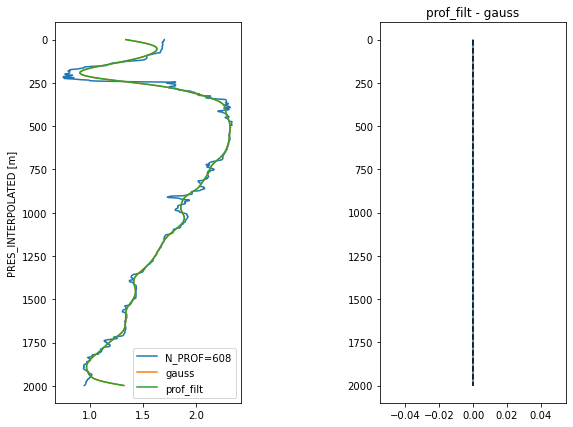

In [236]:
plt.figure(figsize=(15,7))

plt.subplot(1,3,1)
plt.plot(f, x, label='N_PROF={}'.format(f_num))
plt.plot(f_l_gauss, x, label='gauss')
plt.plot(prof_filt, x, label='prof_filt')
plt.gca().invert_yaxis()
plt.ylabel('PRES_INTERPOLATED [m]')
plt.legend()

plt.subplot(1,3,2)
plt.plot(prof_filt-f_l_gauss, x)
plt.vlines(0,0,2000, linestyles='dashed', color='black')
plt.gca().invert_yaxis()
plt.title('prof_filt - gauss')

plt.subplots_adjust(wspace=0.75)

This function looks good! It will be used for EKE/MKE calculations to filter the square of a signal of a single profile.

### Function to return all profiles filtered at one scale

Dhruv's suggestion for working with boundaries/nans:
- Create new variable "mask", where mask = 0 when we are in boundary that should be removed and mask = 1 when we are in usable data
- We can select where to plot data using `.where(mask=1)`
- This will keep dimensions the same for plotting and also not nan out any values

UPDATES:
- Mask variable is created and works well
- Problem is that we don't want to use mask to select where to plot, it should be used to select where to filter! Not entirely sure how to do this

In [ ]:
xr.apply_ufunc #xr function to a specific dimension
##broadcast: element applies to single element but wants to be applied to many different dimensions
##vectorization: work around for for loops, speed benefits to not using for loops
##has keyword called vectorization which allows you to do both

#pass another variable for pressure, generalize PRES_INTERPOLATED

In [412]:
def ds_one_scale(ds_interp, scale, variable='TEMP', boundary_correction=False):

    if boundary_correction==True:
        start = ds_interp.PRES_INTERPOLATED.isel(PRES_INTERPOLATED=0).values + (scale-1)
        end = ds_interp.PRES_INTERPOLATED.isel(PRES_INTERPOLATED=-1).values - (scale-1)
        mask = ds_interp.PRES_INTERPOLATED.where(ds_interp.PRES_INTERPOLATED>start).where(ds_interp.PRES_INTERPOLATED<end).values

        mask[np.greater(mask,0)] = 1
        mask[np.isnan(mask)] = 0
        
    if boundary_correction==False:
        mask = np.ones((len(ds_interp.PRES_INTERPOLATED)))
        
    dx = (ds_interp.PRES_INTERPOLATED.isel(PRES_INTERPOLATED=1)-ds_interp.PRES_INTERPOLATED.isel(PRES_INTERPOLATED=0)).values
    N = len(ds_interp.PRES_INTERPOLATED)+1
    lfilter = scale
    sigmafilter = lfilter/np.sqrt(12)
    nfilter = sigmafilter/dx
    
    temp=np.zeros((ds_interp.N_PROF.shape[0],ds_interp.PRES_INTERPOLATED.shape[0]))
    temp[:,:] = filter.gaussian_filter1d(ds_interp[variable], sigma=nfilter, mode='wrap')
    
    ds_filt = xr.DataArray(temp, dims=['N_PROF', 'PRES_INTERPOLATED'], coords={'N_PROF':ds_interp.N_PROF, 'PRES_INTERPOLATED':ds_interp.PRES_INTERPOLATED})
    
    number=np.arange(0,len(ds_filt.N_PROF))
    ds_filt['N_PROF_NEW']=xr.DataArray(number,dims=ds_filt.N_PROF.dims)
    ds_filt['MASK']=xr.DataArray(mask,dims=ds_filt.PRES_INTERPOLATED.dims)
    
    return ds_filt

In [413]:
one_scale = ds_one_scale(aselect,100)

In [414]:
one_scale_bound = ds_one_scale(aselect,100, boundary_correction=True)

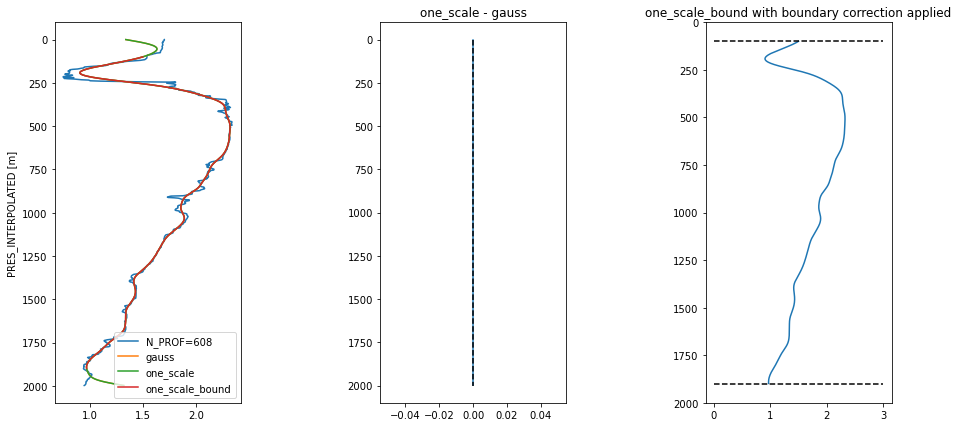

In [415]:
plt.figure(figsize=(15,7))

plt.subplot(1,3,1)
plt.plot(f, x, label='N_PROF={}'.format(f_num))
plt.plot(f_l_gauss, x, label='gauss')
plt.plot(one_scale.sel(N_PROF=f_num), x, label='one_scale')
plt.plot(one_scale_bound.sel(N_PROF=f_num).where(one_scale_bound.MASK==1), one_scale_bound.PRES_INTERPOLATED, label='one_scale_bound')
plt.gca().invert_yaxis()
plt.ylabel('PRES_INTERPOLATED [m]')
plt.legend()

plt.subplot(1,3,2)
plt.plot(one_scale.sel(N_PROF=f_num)-f_l_gauss, x)
plt.vlines(0,0,2000, linestyles='dashed', color='black')
plt.gca().invert_yaxis()
plt.title('one_scale - gauss')

plt.subplot(1,3,3)
plt.plot(one_scale_bound.sel(N_PROF=f_num).where(one_scale_bound.MASK==1), one_scale_bound.PRES_INTERPOLATED)
plt.hlines(100,0,3, linestyles='dashed', color='black')
plt.hlines(1900,0,3, linestyles='dashed', color='black')
plt.ylim(0,2000)
plt.gca().invert_yaxis()
plt.title('one_scale_bound with boundary correction applied')

plt.subplots_adjust(wspace=0.75)

ORIGINAL COMMENTS:
Okay this function looks good! It matches the results from Dhruv's function for this profile, and the boundary correction seems to work well at removing the length of filter scale at each end of a profile. Now to make another function that returns multiple filter scales at once.

NEW COMMENTS:
The mask feature is currently working by selecting the results of filtering within a certain condition. However what it should really be doing is selecting only this region to be filtered, and assigning the boundary regions as nan.

### Function to return all profiles filtered at multiple scales

In [419]:
#break it up into multiple functions:
    #create list of filter scales (this can use log vs linear flag)
    #this should rely on the previous functions!
    
#import lib.reload
    #use to import .py file after making changes

In [409]:
def ds_multi_scale(ds_interp, first, last, num, log=False, variable='TEMP', boundary_correction=False):
    
    if log==True:
        first_exp = np.log10(first)
        last_exp = np.log10(last)
        lfilters = np.logspace(first_exp,last_exp,num)
        
        sigmafilters = np.empty_like(lfilters)
        nfilters = np.empty_like(lfilters)
        for n,l in enumerate(lfilters):
            sigmafilters[n]=l/np.sqrt(12)
            nfilters[n] = sigmafilters[n]/dx
            
    if log==False:
        lfilters = np.linspace(first,last,num)
        
        sigmafilters = np.empty_like(lfilters)
        nfilters = np.empty_like(lfilters)
        for n,l in enumerate(lfilters):
            sigmafilters[n]=l/np.sqrt(12)
            nfilters[n] = sigmafilters[n]/dx
            
    if boundary_correction==True:
        start = ds_interp.PRES_INTERPOLATED.isel(PRES_INTERPOLATED=0).values + (scale-1)
        end = ds_interp.PRES_INTERPOLATED.isel(PRES_INTERPOLATED=-1).values - (scale-1)
        mask = ds_interp.PRES_INTERPOLATED.where(ds_interp.PRES_INTERPOLATED>start).where(ds_interp.PRES_INTERPOLATED<end).values

        mask[np.greater(mask,0)] = 1
        mask[np.isnan(mask)] = 0
        
    if boundary_correction==False:
        mask = np.ones((len(ds_interp.PRES_INTERPOLATED)))
    
    
    temp=np.zeros((ds_interp.N_PROF.shape[0],ds_interp.PRES_INTERPOLATED.shape[0],num))
    for n in range(0,num):
        temp[:,:,n] = filter.gaussian_filter1d(ds_interp[variable], sigma=nfilters[n], mode='wrap')
    
    ds_filt = xr.DataArray(temp, dims=['N_PROF', 'PRES_INTERPOLATED', 'FILT_SCALE'], 
                           coords={'N_PROF':ds_interp.N_PROF, 'PRES_INTERPOLATED':ds_interp.PRES_INTERPOLATED, 'FILT_SCALE':lfilters})
    
    number=np.arange(0,len(ds_filt.N_PROF))
    ds_filt['N_PROF_NEW']=xr.DataArray(number,dims=ds_filt.N_PROF.dims)
    ds_filt['MASK']=xr.DataArray(mask,dims=ds_filt.PRES_INTERPOLATED.dims)
    
    
    return ds_filt

In [410]:
multi_lin_False = ds_multi_scale(aselect,10,500,50)
multi_log_False = ds_multi_scale(aselect,10,500,50, log=True)

multi_lin_True = ds_multi_scale(aselect,10,500,50, boundary_correction=True)
multi_log_True = ds_multi_scale(aselect,10,500,50, boundary_correction=True, log=True)

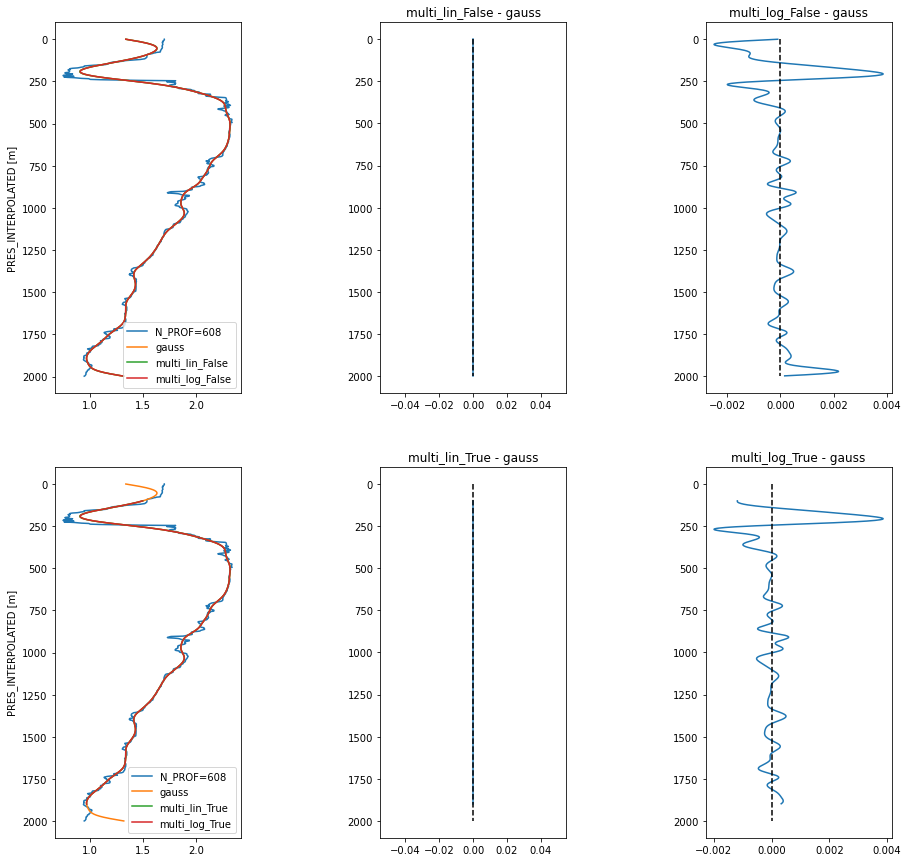

In [411]:
plt.figure(figsize=(15,15))

plt.subplot(2,3,1)
plt.plot(f, x, label='N_PROF={}'.format(f_num))
plt.plot(f_l_gauss, x, label='gauss')
plt.plot(multi_lin_False.sel(N_PROF=f_num).sel(FILT_SCALE=100), x, label='multi_lin_False')
plt.plot(multi_log_False.sel(N_PROF=f_num).isel(FILT_SCALE=29), x, label='multi_log_False')
plt.gca().invert_yaxis()
plt.ylabel('PRES_INTERPOLATED [m]')
plt.legend()

plt.subplot(2,3,2)
plt.plot(multi_lin_False.sel(N_PROF=f_num).sel(FILT_SCALE=100)-f_l_gauss, x)
plt.vlines(0,0,2000, linestyles='dashed', color='black')
plt.gca().invert_yaxis()
plt.title('multi_lin_False - gauss')

plt.subplot(2,3,3)
plt.plot(multi_log_False.sel(N_PROF=f_num).isel(FILT_SCALE=29)-f_l_gauss, x)
plt.vlines(0,0,2000, linestyles='dashed', color='black')
plt.gca().invert_yaxis()
plt.title('multi_log_False - gauss')

plt.subplot(2,3,4)
plt.plot(f, x, label='N_PROF={}'.format(f_num))
plt.plot(f_l_gauss, x, label='gauss')
plt.plot(multi_lin_True.sel(N_PROF=f_num).sel(FILT_SCALE=100).where(multi_lin_True.MASK==1), x, label='multi_lin_True')
plt.plot(multi_log_True.sel(N_PROF=f_num).isel(FILT_SCALE=29).where(multi_log_True.MASK==1), x, label='multi_log_True')
plt.gca().invert_yaxis()
plt.ylabel('PRES_INTERPOLATED [m]')
plt.legend()

plt.subplot(2,3,5)
plt.plot(multi_lin_True.sel(N_PROF=f_num).sel(FILT_SCALE=100).where(multi_lin_True.MASK==1)-f_l_gauss, x)
plt.vlines(0,0,2000, linestyles='dashed', color='black')
plt.gca().invert_yaxis()
plt.title('multi_lin_True - gauss')

plt.subplot(2,3,6)
plt.plot(multi_log_True.sel(N_PROF=f_num).isel(FILT_SCALE=29).where(multi_log_True.MASK==1)-f_l_gauss, x)
plt.vlines(0,0,2000, linestyles='dashed', color='black')
plt.gca().invert_yaxis()
plt.title('multi_log_True - gauss')

plt.subplots_adjust(wspace=0.75)

This is pretty close, and I think the slight deviation we see in multi_log - gauss is because multi_lin has a filter scale of exactly 100 while the closest for multi_log is ~101.3. So everything with this function works except for how mask interfaces with filtering!

## MKE/EKE method from Steinberg paper

These eqations are for energy at one spatial scale, where the eddy kinetic energy at scales smaller than the filter scale (EKE) and mean kinetic energy at scales larger than the filter scale (MKE) are:

$$
MKE = <u>^2
$$
$$
EKE = <u^2> - <u>^2
$$

(based on this paper: [Steinberg](https://journals.ametsoc.org/view/journals/phoc/52/8/JPO-D-21-0269.1.xml))

In [285]:
aselect_filt = ds_multi_scale(aselect,10,500,50)

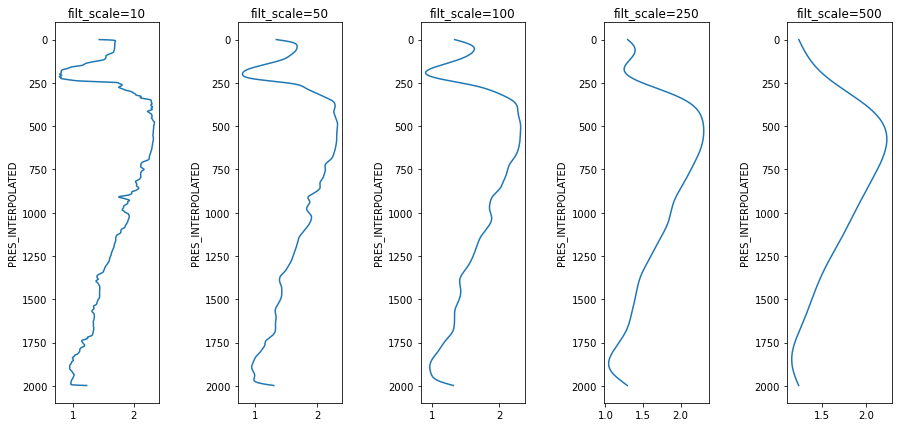

In [355]:
#this is with my_stats functions!

plt.figure(figsize=(15,7))

plt.subplot(1,5,1)
aselect_filt.isel(N_PROF=0).sel(FILT_SCALE=10.).plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title('filt_scale=10')

plt.subplot(1,5,2)
aselect_filt.isel(N_PROF=0).sel(FILT_SCALE=50.).plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title('filt_scale=50')

plt.subplot(1,5,3)
aselect_filt.isel(N_PROF=0).sel(FILT_SCALE=100.).plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title('filt_scale=100')

plt.subplot(1,5,4)
aselect_filt.isel(N_PROF=0).sel(FILT_SCALE=250.).plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title('filt_scale=250')

plt.subplot(1,5,5)
aselect_filt.isel(N_PROF=0).sel(FILT_SCALE=500.).plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title('filt_scale=500')

plt.subplots_adjust(wspace=0.75)

In [356]:
l=35
aselect_filt_l=aselect_filt.sel(FILT_SCALE=100)

MKE=aselect_filt_l**2

Text(0.5, 1.0, 'Argo Box')

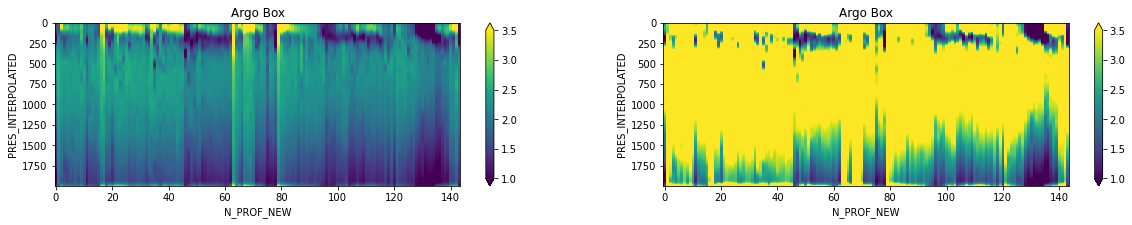

In [357]:
plt.figure(figsize=(20,3))

plt.subplot(1,2,1)
aselect_filt_l.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',vmin=1,vmax=3.5)
plt.gca().invert_yaxis()
plt.title('Argo Box')

plt.subplot(1,2,2)
MKE.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',vmin=1,vmax=3.5)
plt.gca().invert_yaxis()
plt.title('Argo Box')

In [358]:
u2 = aselect.TEMP**2
u2_filt = prof_one_scale(u2,100)

EKE = u2_filt - MKE

Text(0.5, 1.0, 'Argo Box')

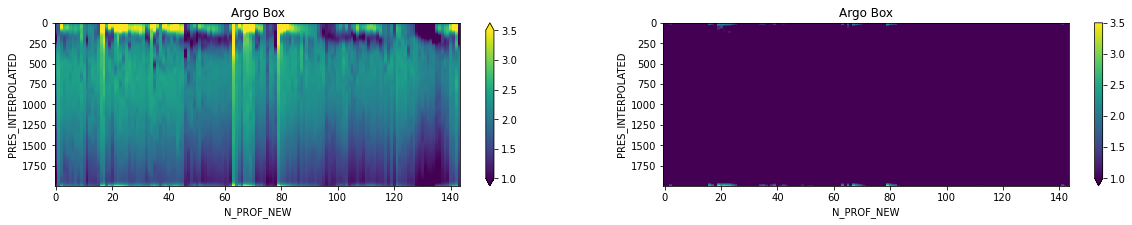

In [359]:
plt.figure(figsize=(20,3))

plt.subplot(1,2,1)
aselect_filt_l.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',vmin=1,vmax=3.5)
plt.gca().invert_yaxis()
plt.title('Argo Box')

plt.subplot(1,2,2)
EKE.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',vmin=1,vmax=3.5)
plt.gca().invert_yaxis()
plt.title('Argo Box')